In [1]:
import os
import json
import re

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pprint import pprint

In [2]:

def flatten_dict(d):
    r = {}
    q = [("", x) for x in d.items()]
    while len(q) > 0:
        p, (k, v) = q.pop(0)
        if type(v) is not dict:
            r[f"{p}{k}".lower()] = v
        else:
            for x in v.items():
                q.append((f"{p}{k}_", x))
    return r


def parse_final_results_ndt7(f):
    md = json.load(f)["end"]["sum_received"]
    md["megabits_per_second"] = md['bits_per_second']/1e6
    return flatten_dict(md)


def load_experiment_results(exp_dir):
    file_dicts = []
    for subdir in os.listdir(exp_dir):
        print(f"Dir: {subdir}")
        if "lan3" not in subdir:
            continue
        splitted_subdir = subdir.split("_")
        speed = splitted_subdir[1]
        latency = splitted_subdir[2]
        pktloss = splitted_subdir[3]
        aqm = '_'.join(splitted_subdir[4:])
        subdir_path = os.path.join(exp_dir, subdir)
        for filename in os.listdir(subdir_path):
            print(end=f"  File: {filename} ")
            datetime = pd.to_datetime(re.split(r'_|\.', filename)[1])
            filepath = os.path.join(subdir_path, filename)
            try:
                with open(filepath) as f:
                    r = parse_final_results_ndt7(f)
                r["speed"] = speed
                r["latency"] = latency
                r["pktloss"] = pktloss
                r["aqm"] = aqm
                r["datetime"] = datetime
                file_dicts.append(r)
                print("(GOOD)")
            except:
                print("(FAIL)")
                continue

    return pd.DataFrame(file_dicts)


# exp_dir = "../data/data_json_iperf/"
# exp_dir = "../data/data_json_iperf_900_notshaped/"
exp_dir = "../data/data_json_iperf_900_shaped/"
final_df = load_experiment_results(exp_dir)

Dir: lan3_900_10_0_fq_codel
  File: iperf3_20250314-125522.jsonl (GOOD)
  File: iperf3_20250314-125545.jsonl (GOOD)
  File: iperf3_20250314-125619.jsonl (GOOD)
  File: iperf3_20250314-125459.jsonl (GOOD)
  File: iperf3_20250314-125436.jsonl (GOOD)
  File: iperf3_20250314-125557.jsonl (GOOD)
  File: iperf3_20250314-125448.jsonl (GOOD)
  File: iperf3_20250314-125608.jsonl (GOOD)
  File: iperf3_20250314-125534.jsonl (GOOD)
  File: iperf3_20250314-125511.jsonl (GOOD)
Dir: .DS_Store
Dir: lan3_900_10_0_codel
  File: iperf3_20250314-125815.jsonl (GOOD)
  File: iperf3_20250314-125707.jsonl (GOOD)
  File: iperf3_20250314-125719.jsonl (GOOD)
  File: iperf3_20250314-125741.jsonl (GOOD)
  File: iperf3_20250314-125645.jsonl (GOOD)
  File: iperf3_20250314-125633.jsonl (GOOD)
  File: iperf3_20250314-125656.jsonl (GOOD)
  File: iperf3_20250314-125804.jsonl (GOOD)
  File: iperf3_20250314-125730.jsonl (GOOD)
  File: iperf3_20250314-125753.jsonl (GOOD)
Dir: lan3_900_10_0_no_aqm
  File: iperf3_20250314-12

In [3]:
final_df.iloc[0]

start                                    0
end                              10.020589
seconds                          10.020589
bytes                            780049272
bits_per_second           622757222.754072
sender                                True
megabits_per_second             622.757223
speed                                  900
latency                                 10
pktloss                                  0
aqm                               fq_codel
datetime               2025-03-14 12:55:22
Name: 0, dtype: object

In [4]:

def generate_boxplots(df, result_col, result_label):
    ylim = (df[result_col].min()*0.9, df[result_col].max()*1.1)
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    for i, (speed, speed_df) in enumerate(sorted(df.groupby("speed"))):
        ax = axes[i//3][i%3]
        xlabels = []
        yvalues = []
        # ylim = (speed_df[result_col].min()*0.9, speed_df[result_col].max()*1.1)
        for aqm, aqm_df in sorted(speed_df.groupby("aqm")):
            xlabels.append(aqm)
            yvalues.append(aqm_df[result_col])
        ax.boxplot(yvalues, positions=range(len(xlabels)))
        ax.set_xticklabels(xlabels)
        ax.set_xlabel("Queueing Discipline")
        ax.set_ylabel(result_label)
        # ax.set_ylim(ylim)
        ax.set_title(f"Bandwidth: {speed} Mbps")
    # plt.suptitle(result_label)
    plt.tight_layout()
    plt.show()
    return fig


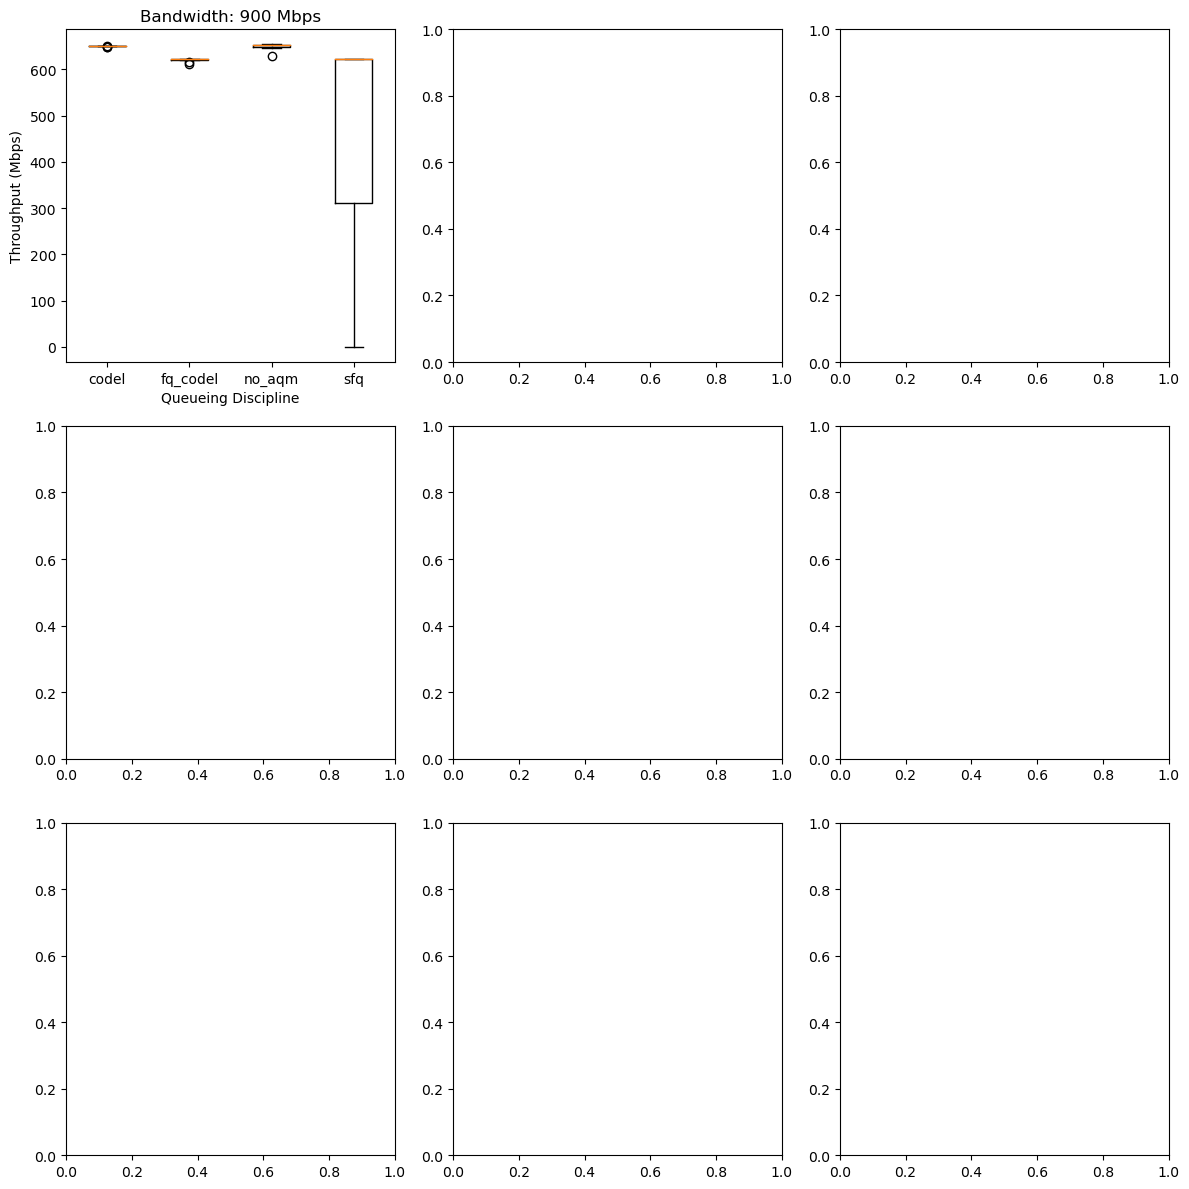

In [5]:
fig = generate_boxplots(final_df, "megabits_per_second", "Throughput (Mbps)")

In [6]:
# fig = generate_boxplots(final_df, "upload_latency_value_2", "Latency (ms)")

In [7]:

def generate_ecdfs(df, result_col, result_label):
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    for i, (speed, speed_df) in enumerate(sorted(df.groupby("speed"))):
        ax = axes[i//3][i%3]
        for aqm, aqm_df in sorted(speed_df.groupby("aqm")):
            sns.ecdfplot(aqm_df[result_col], label=aqm, ax=ax)
        ax.set_xlabel(result_label)
        ax.set_ylabel("CDF")
        ax.set_title(f"Bandwidth: {speed} Mbps")
        ax.legend()
    plt.tight_layout()
    return fig


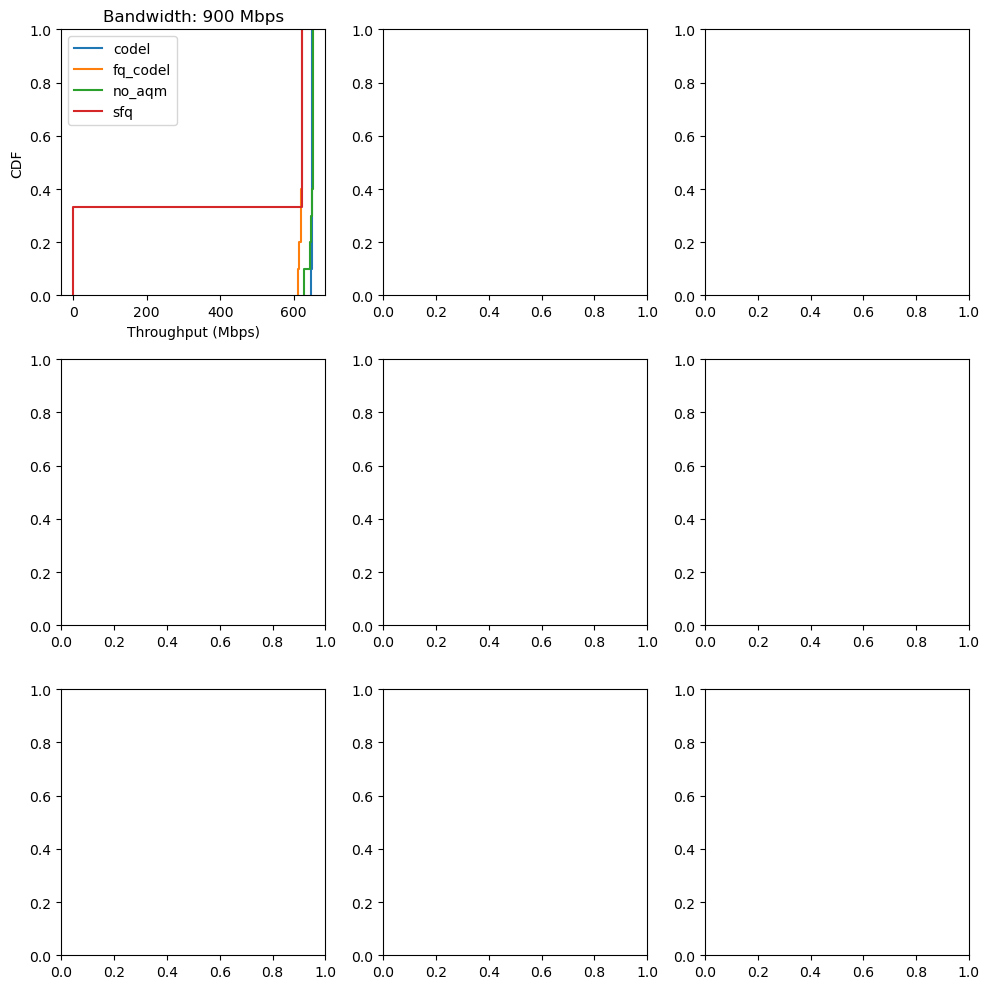

In [8]:
fig = generate_ecdfs(final_df, "megabits_per_second", "Throughput (Mbps)")

fig.savefig("figures/cdf_tput_estimate_iperf3.png")

In [9]:
# fig = generate_ecdfs(final_df, "upload_latency_value", "Latency (ms)")